# look at the variance per frequency band


In [1]:
import os, sys, shutil
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xgcm

from mitequinox.utils import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1)
#w = cluster.scale(40)
w = cluster.scale(5) # postprocessing

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.39.89:52753 Dashboard: http://10.135.39.89:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
# load data


In [5]:
ds = xr.open_zarr(work_data_dir+'spectra/%s_variance_per_band.zarr'%('SSUV'))
print(ds)

# add coriolis parameters to dataset
#omega = 7.3/100000 # XY, 
# see, http://mitgcm.org/public/r2_manual/final/code_reference/vdb/names/R.htm
f = 2*omega_earth*np.sin(np.deg2rad(ds['YC']))
rps2cpd=86400/2./np.pi

<xarray.Dataset>
Dimensions:      (band: 4, face: 13, i: 1080, j: 1080)
Coordinates:
    Depth        (face, j, i) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 1080, 1080)>
    XC           (face, j, i) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 1080, 1080)>
    YC           (face, j, i) float32 dask.array<shape=(13, 1080, 1080), chunksize=(1, 1080, 1080)>
  * band         (band) object 'semidiurnal' 'diurnal' 'inertial' 'subdiurnal'
  * face         (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i            (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j            (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    mask         (face, j, i) int8 dask.array<shape=(13, 1080, 1080), chunksize=(1, 1080, 1080)>
Data variables:
    uv_variance  (band, face, j, i) float64 dask.array<shape=(4, 13, 1080, 1080), chunksize=(1, 1, 1080, 1080)>


In [6]:
# mask some points
ds = ds.where(ds.Depth>500.).where(np.abs(ds.YC)<60.)
ds = ds.persist()

---
## plot global fields


(<Figure size 1080x1080 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x2af015279a20>)

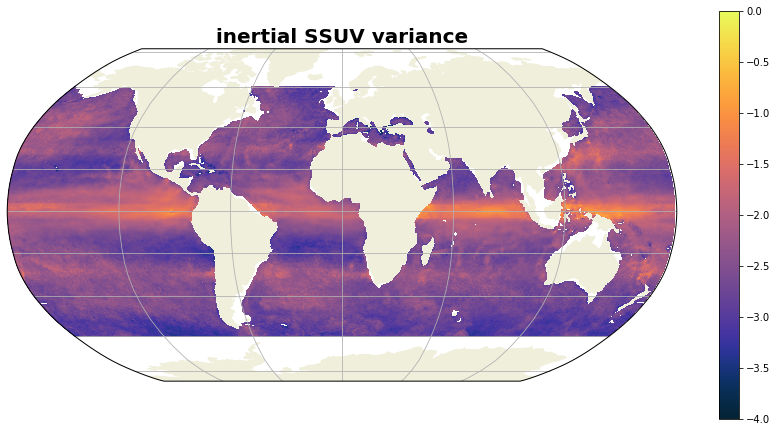

In [8]:
band = 'inertial'
toplt = np.log10(ds.uv_variance.sel(band=band))
plot_pretty(toplt, title=band+' SSUV variance', 
            vmin=-4., vmax=0., cmap=cm.thermal, 
            ignore_face=[6], colorbar=True, colorbar_kwargs={'shrink':.5})

---
## joint pdf

In [9]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


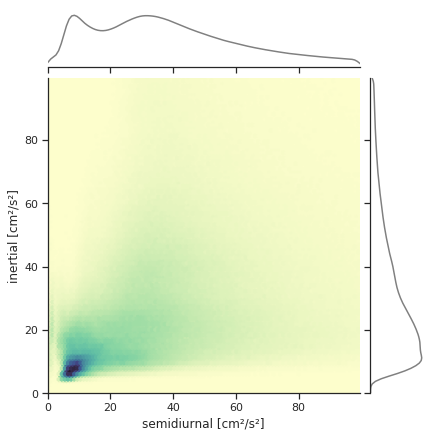

In [10]:
def jointplot(bandx, bandy, xbins, ybins, face=range(13), log=False):
    # (m/s)² -> (cm/s)²
    x = ds.uv_variance.sel(face=face, band=bandx).values.flatten()*1e4
    y = ds.uv_variance.sel(face=face, band=bandy).values.flatten()*1e4
    if log:
        x = np.log10(x)
        y = np.log10(y)
        lxbins=np.arange(*xbins)
        lybins=np.arange(*ybins)        
    else:
        lxbins=np.arange(0.,*xbins)
        lybins=np.arange(0.,*ybins)
    g = sns.JointGrid(x, y, xlim=(lxbins[0],lxbins[-1]),ylim=(lybins[0],lybins[-1]))
    #
    sns.kdeplot(x, color='.5', clip=(lxbins[0],lxbins[-1]), ax=g.ax_marg_x, vertical=False)
    sns.kdeplot(y, color='.5', clip=(lybins[0],lybins[-1]), ax=g.ax_marg_y, vertical=True)
    #
    g = g.plot_joint(plt.hexbin, cmap=cm.deep, extent=[lxbins[0], lxbins[-1], lybins[0], lybins[-1]])
    #g = g.plot_joint(sns.regplot)
    #
    if log:
        g.set_axis_labels(bandx+' log10 [cm²/s²]', bandy+' log10 [cm²/s²]')
    else:
        g.set_axis_labels(bandx+' [cm²/s²]', bandy+' [cm²/s²]')
    return g

g = jointplot('semidiurnal','inertial',(100.,.5),(100.,.5))
#

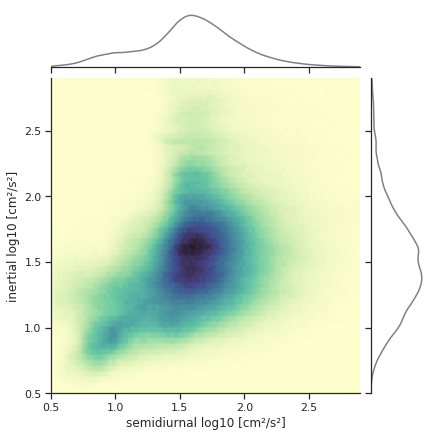

In [11]:
g = jointplot('semidiurnal','inertial',(0.5,3.,.1),(0.5,3.,.1), log=True)

---

In [17]:
w = cluster.scale_up(30)

In [ ]:
client.restart()

In [12]:
cluster.close()